In [328]:
!pip install -r requirements.txt

In [401]:
from src.csv_sql import CSVtoSQL
import glob
import os
from IPython.display import display, HTML
from tabulate import tabulate
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
## for model optimization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, precision_recall_curve,average_precision_score, auc,average_precision_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
import xgboost

In [417]:
def predict_fit(model, folds, params_, metric, X_train, y_train, X_test, y_test):
    """
    Perform grid search optimization with the supplied parameters, fit the model, predict on test data,
    compute accuracy, precision, recall, and ROC curve.

    Parameters:
        model (object): The machine learning model object.
        folds (int): The number of cross-validation folds for grid search.
        params_ (dict): The parameters to be tuned in the grid search.
        metric (str): The scoring metric used for grid search evaluation.
        X_train (array-like): The training features.
        y_train (array-like): The training labels.
        X_test (array-like): The test features.
        y_test (array-like): The test labels.

    Returns:
        dict: A dictionary containing the results including ROC curve, predictions, model, accuracy, feature importance,
              precision, and recall.
    """
    grid = GridSearchCV(model, params_, cv=folds, scoring=metric)
    grid.fit(X_train, y_train)

    if isinstance(model, LogisticRegression):
        feature_importance = grid.best_estimator_.coef_
    else:
        print("Features")
        feature_importance = grid.best_estimator_.feature_importances_

    y_pred = grid.best_estimator_.predict(X_test)
    probabilities = grid.predict_proba(X_test)
    accuracy = roc_auc_score(y_test, probabilities, multi_class='ovo', average='macro')

    fpr_1, tpr_1, threshold_1 = roc_curve(y_test, probabilities[:, 0], pos_label=0)
    fpr_2, tpr_2, threshold_2 = roc_curve(y_test, probabilities[:, 1], pos_label=1)
    fpr_3, tpr_3, threshold_3 = roc_curve(y_test, probabilities[:, 2], pos_label=2)
    
    precision_1, recall_1, thresholds_1 = precision_recall_curve(y_test==0, probabilities[:, 0])
    precision_2, recall_2, thresholds_2 = precision_recall_curve(y_test==1, probabilities[:, 1])
    precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test==2, probabilities[:, 2])

    return {'tpr_1': tpr_1, 'fpr_1': fpr_1, 'fpr_2': fpr_2, 'tpr_2': tpr_2, 'fpr_3': fpr_3, 'tpr_3': tpr_3,
            'predictions': y_pred, 'model': grid.best_estimator_, 'accuracy': accuracy,
            'feature_importance': feature_importance, 'pr_1': precision_1, 're_1': recall_1,
            'pr_2': precision_2, 're_2': recall_2, 'pr_3': precision_3, 're_3': recall_3,'probabilities':probabilities}

In [330]:


file_pattern = "data/*.csv"


files = glob.glob(file_pattern)


normalized_files = [os.path.normpath(file) for file in files]


In [331]:
file_names = {(normalized_files[0].split("data")[-1].split('.csv')[0]+"_table").split("/")[-1]:normalized_files[0],(normalized_files[1].split("data")[-1].split('.csv')[0]+"_table").split("/")[-1]:normalized_files[1],(normalized_files[2].split("data")[-1].split('.csv')[0]+"_table").split("/")[-1]:normalized_files[2]}
table_names = list(file_names.keys())
print("These are the table names {}".format(",".join(table_names)))
def generate_tables(key,val):

    csv_file = val
    delimiter,header,column_types= CSVtoSQL.csv_sniffer(csv_file)
    delimiter, headers, column_data_types = CSVtoSQL.csv_sniffer(csv_file)
    conn, cursor = CSVtoSQL.write_csv_to_sql(delimiter, headers, column_data_types, key, csv_file)
    query = "SELECT * FROM {} LIMIT 5;".format(key)
    result,rw,hd = CSVtoSQL.execute_and_format(conn, query)
    display(HTML(tabulate(rw, headers=hd, tablefmt="html", stralign='center')))
    return conn, cursor


These are the table names GlobalLandTemperaturesByCountry_table,worldhappinessreport2021_table,worldhappinessreport_table


In [332]:
key_list=list(file_names.keys())

In [333]:
file_names[key_list[0]]

'data/GlobalLandTemperaturesByCountry.csv'

In [334]:
conn_1, cursor_1  = generate_tables(key_list[0],file_names[key_list[0]])

In [335]:
conn_2, cursor_2  = generate_tables(key_list[1],file_names[key_list[1]])

In [336]:
conn_3, cursor_3  = generate_tables(key_list[2],file_names[key_list[2]])

In [337]:
#convert year column to datetime
result_0,rw_0,hd_0 =CSVtoSQL.execute_and_format(conn_1,"select datetime(dt) as datetime,AverageTemperature, AverageTemperatureUncertainty, Country from GlobalLandTemperaturesByCountry_table WHERE strftime('%Y', datetime) > '2005';")

In [338]:
#create year column in the 2021 WorldHappinessReportData
result_1,rw_1,hd_1 =CSVtoSQL.execute_and_format(conn_2,"select * ,2021 as year from worldhappinessreport2021_table;")

In [339]:
result_2,rw_2,hd_2 =CSVtoSQL.execute_and_format(conn_3,"select * from worldhappinessreport_table;")

In [340]:
display(HTML(tabulate(rw_2[0:2], headers=hd_2, tablefmt="html", stralign='center')))
# year column is created

# In the above code I have extensively leveraged sqlite tables to manipulate and create in memory datafiles -- going forward I will use pandas to make life a little easier

In [341]:
# Going forward I will use pandas dataframe to make life a little easier
df_report_2021 = pd.DataFrame(rw_1,columns=hd_1)
df_report_all_other_years = pd.DataFrame(rw_2,columns=hd_2)

In [342]:
df_report_all_other_years.rename(columns={'Life Ladder':'Ladder score','Log GDP per capita':'Logged GDP per capita','Healthy life expectancy at birth':'Healthy life expectancy'},inplace=True)
df_report_all_other_years.drop(columns=['Positive affect','Negative affect'],inplace=True)

In [343]:
df_report_all_other_years=df_report_all_other_years.astype('object')

In [344]:
df_report_2021=df_report_2021.astype('object')

In [345]:
dataset = df_report_all_other_years.merge(df_report_2021[(df_report_all_other_years.columns.to_list())],how='outer')

In [346]:
data_regional_indicator = df_report_2021[['\ufeffCountry name','Regional indicator']].join(dataset.set_index('\ufeffCountry name'),on='\ufeffCountry name', how='inner').reset_index().drop('index',axis=1)

In [347]:
df_temp=data_regional_indicator[data_regional_indicator.columns.to_list()[2:]].replace('',np.nan).astype('float')
#data_regional_indicator[data_regional_indicator.columns.to_list()[2:]].isnull().mean()#.corr('pearson')

data_regional_indicator[df_temp.columns.to_list()] = df_temp

In [348]:
data_regional_indicator.fillna(method='ffill',inplace=True)

In [349]:
data_regional_indicator.columns.to_list()

['\ufeffCountry name',
 'Regional indicator',
 'year',
 'Ladder score',
 'Logged GDP per capita',
 'Social support',
 'Healthy life expectancy',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption']

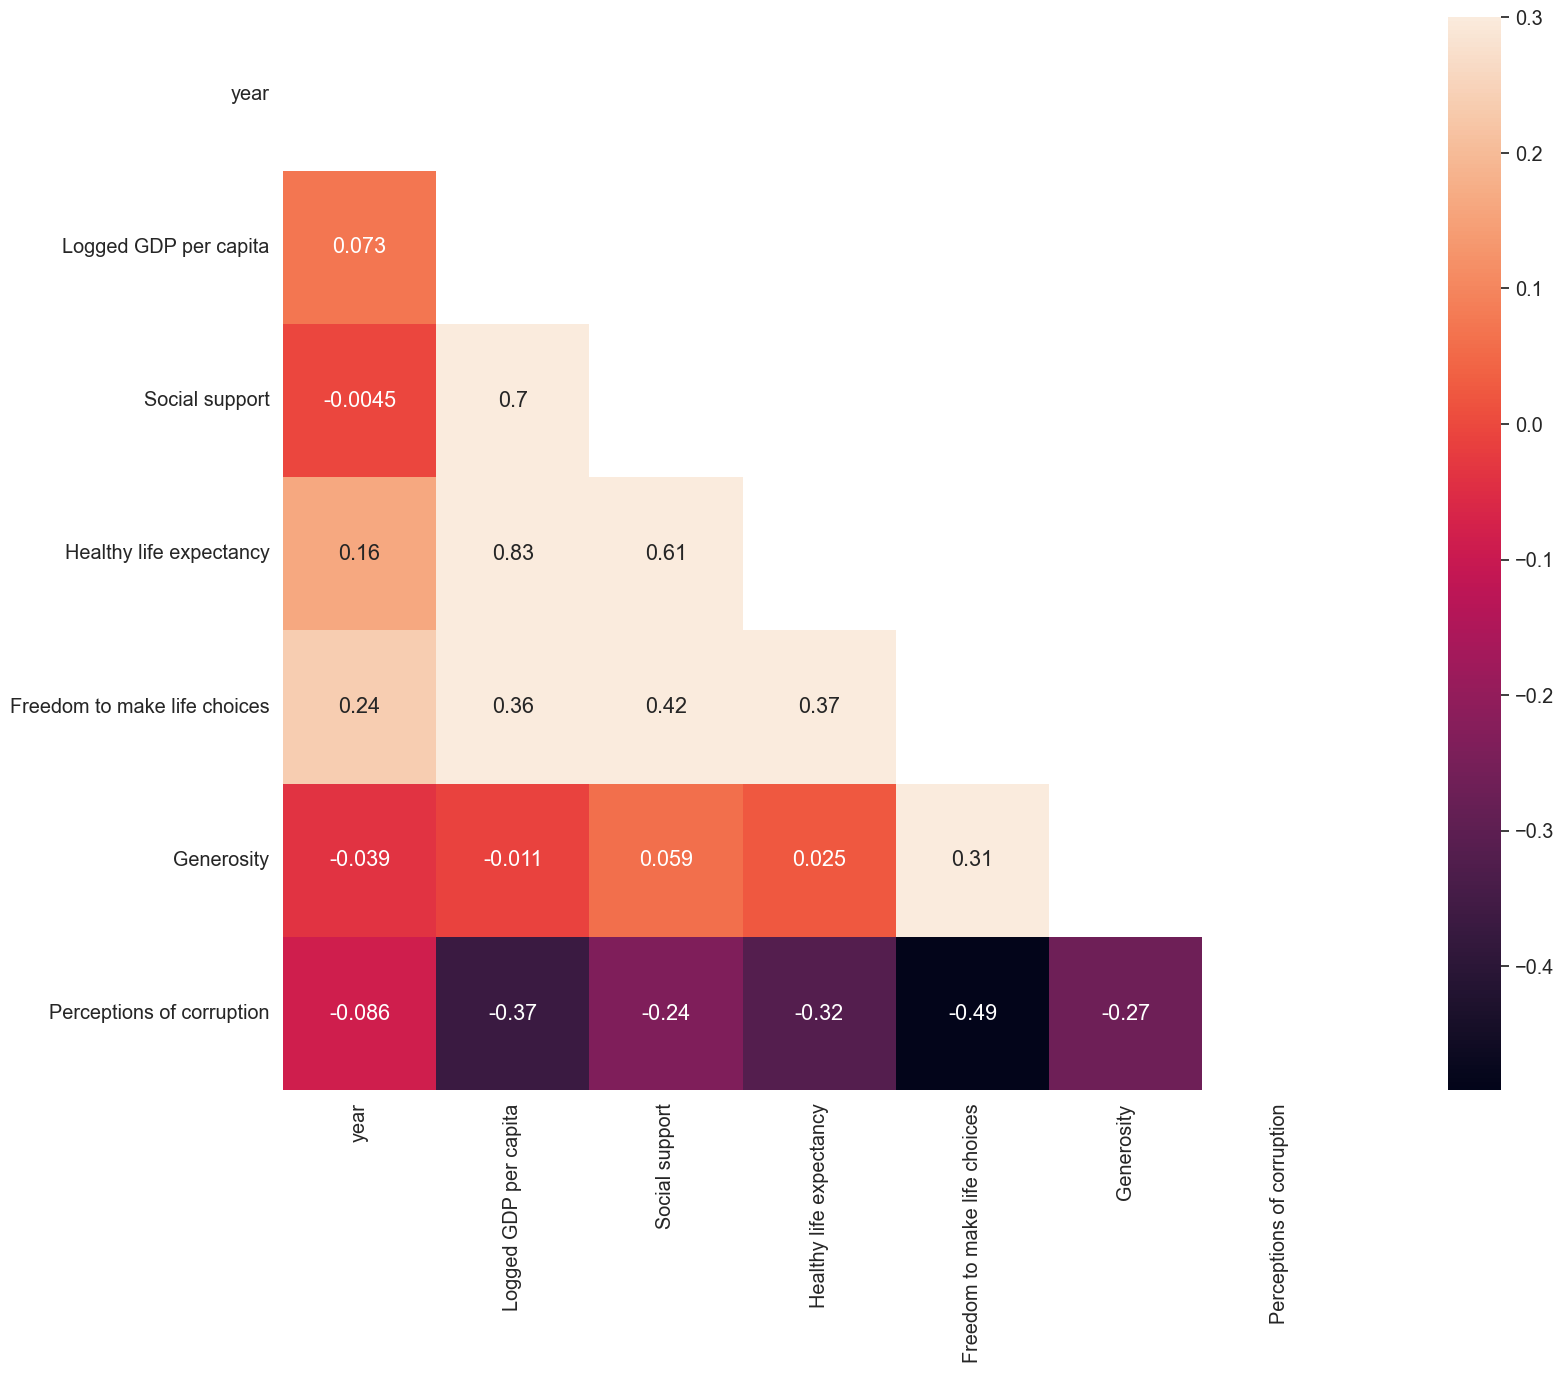

In [350]:
corr = data_regional_indicator.drop(['\ufeffCountry name','Regional indicator','Ladder score'],axis=1).corr('pearson')#np.corrcoef(np.random.randn(10, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 14))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,annot=True)
plt.tight_layout()

## **Columns are not highly correlated with each other--no problem of multicolinearity for the later part.** However,  life expectancy and GDP have some correlation and the same is true about social support.
## Lets create some classes to create a classification problem 

In [351]:
score_2_4 = data_regional_indicator['Ladder score'].apply(lambda x : True if (x>2 and x<=4.0) else False)
score_4_6 = data_regional_indicator['Ladder score'].apply(lambda x : True if (x>4 and x<=6.0) else False)
score_6_8 = data_regional_indicator['Ladder score'].apply(lambda x : True if (x>6 and x<=9.0) else False)
data_regional_indicator['Class'] = ''

In [352]:
data_regional_indicator.loc[data_regional_indicator[score_2_4].index,'Class'] = 0
data_regional_indicator.loc[data_regional_indicator[score_4_6].index,'Class'] = 1
data_regional_indicator.loc[data_regional_indicator[score_6_8].index,'Class'] = 2

In [353]:
data_regional_indicator.rename(columns={'\ufeffCountry name':'Country name'},inplace=True)

## Created three classes depending on the ladder scores. 2-4--Class 0, 4-6 --Class 1, 6-9--Class 2
***The ladder score refers to the happiness score assigned to each country in the World Happiness Report. It is a measure of subjective well-being and happiness, based on responses to survey questions related to life satisfaction. The ladder score is typically represented on a scale from 0 to 10, with 10 indicating the highest level of happiness or life satisfaction. It serves as a way to compare and rank countries based on their happiness levels, providing insights into the overall well-being and quality of life in different nations.***

In [354]:
cols_to_scale = list(data_regional_indicator.drop(['Country name','Regional indicator','year','Class'],axis=1).columns)

Text(0, 0.5, 'Region')

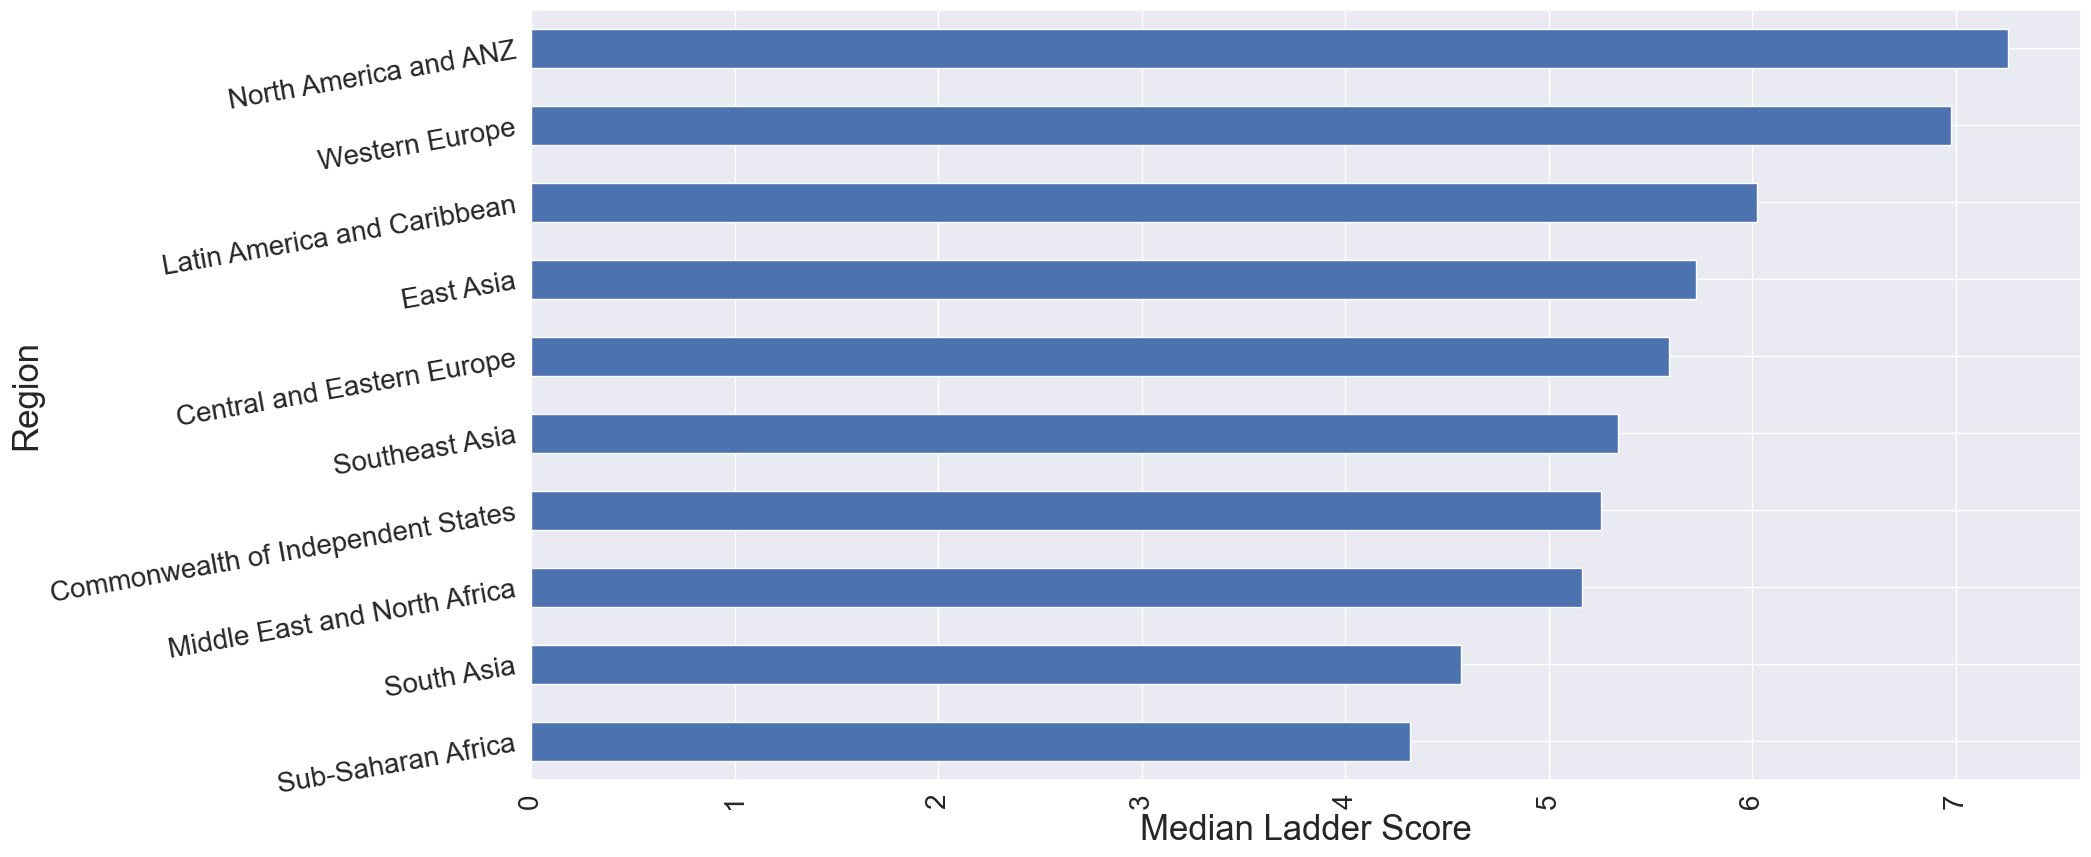

In [355]:
data_regional_indicator.groupby('Regional indicator')['Ladder score'].median().sort_values(ascending=True).plot(kind='barh',figsize=(20,10))
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20,rotation=10)
plt.xlabel('Median Ladder Score',fontsize=25)
plt.ylabel('Region',fontsize=25)

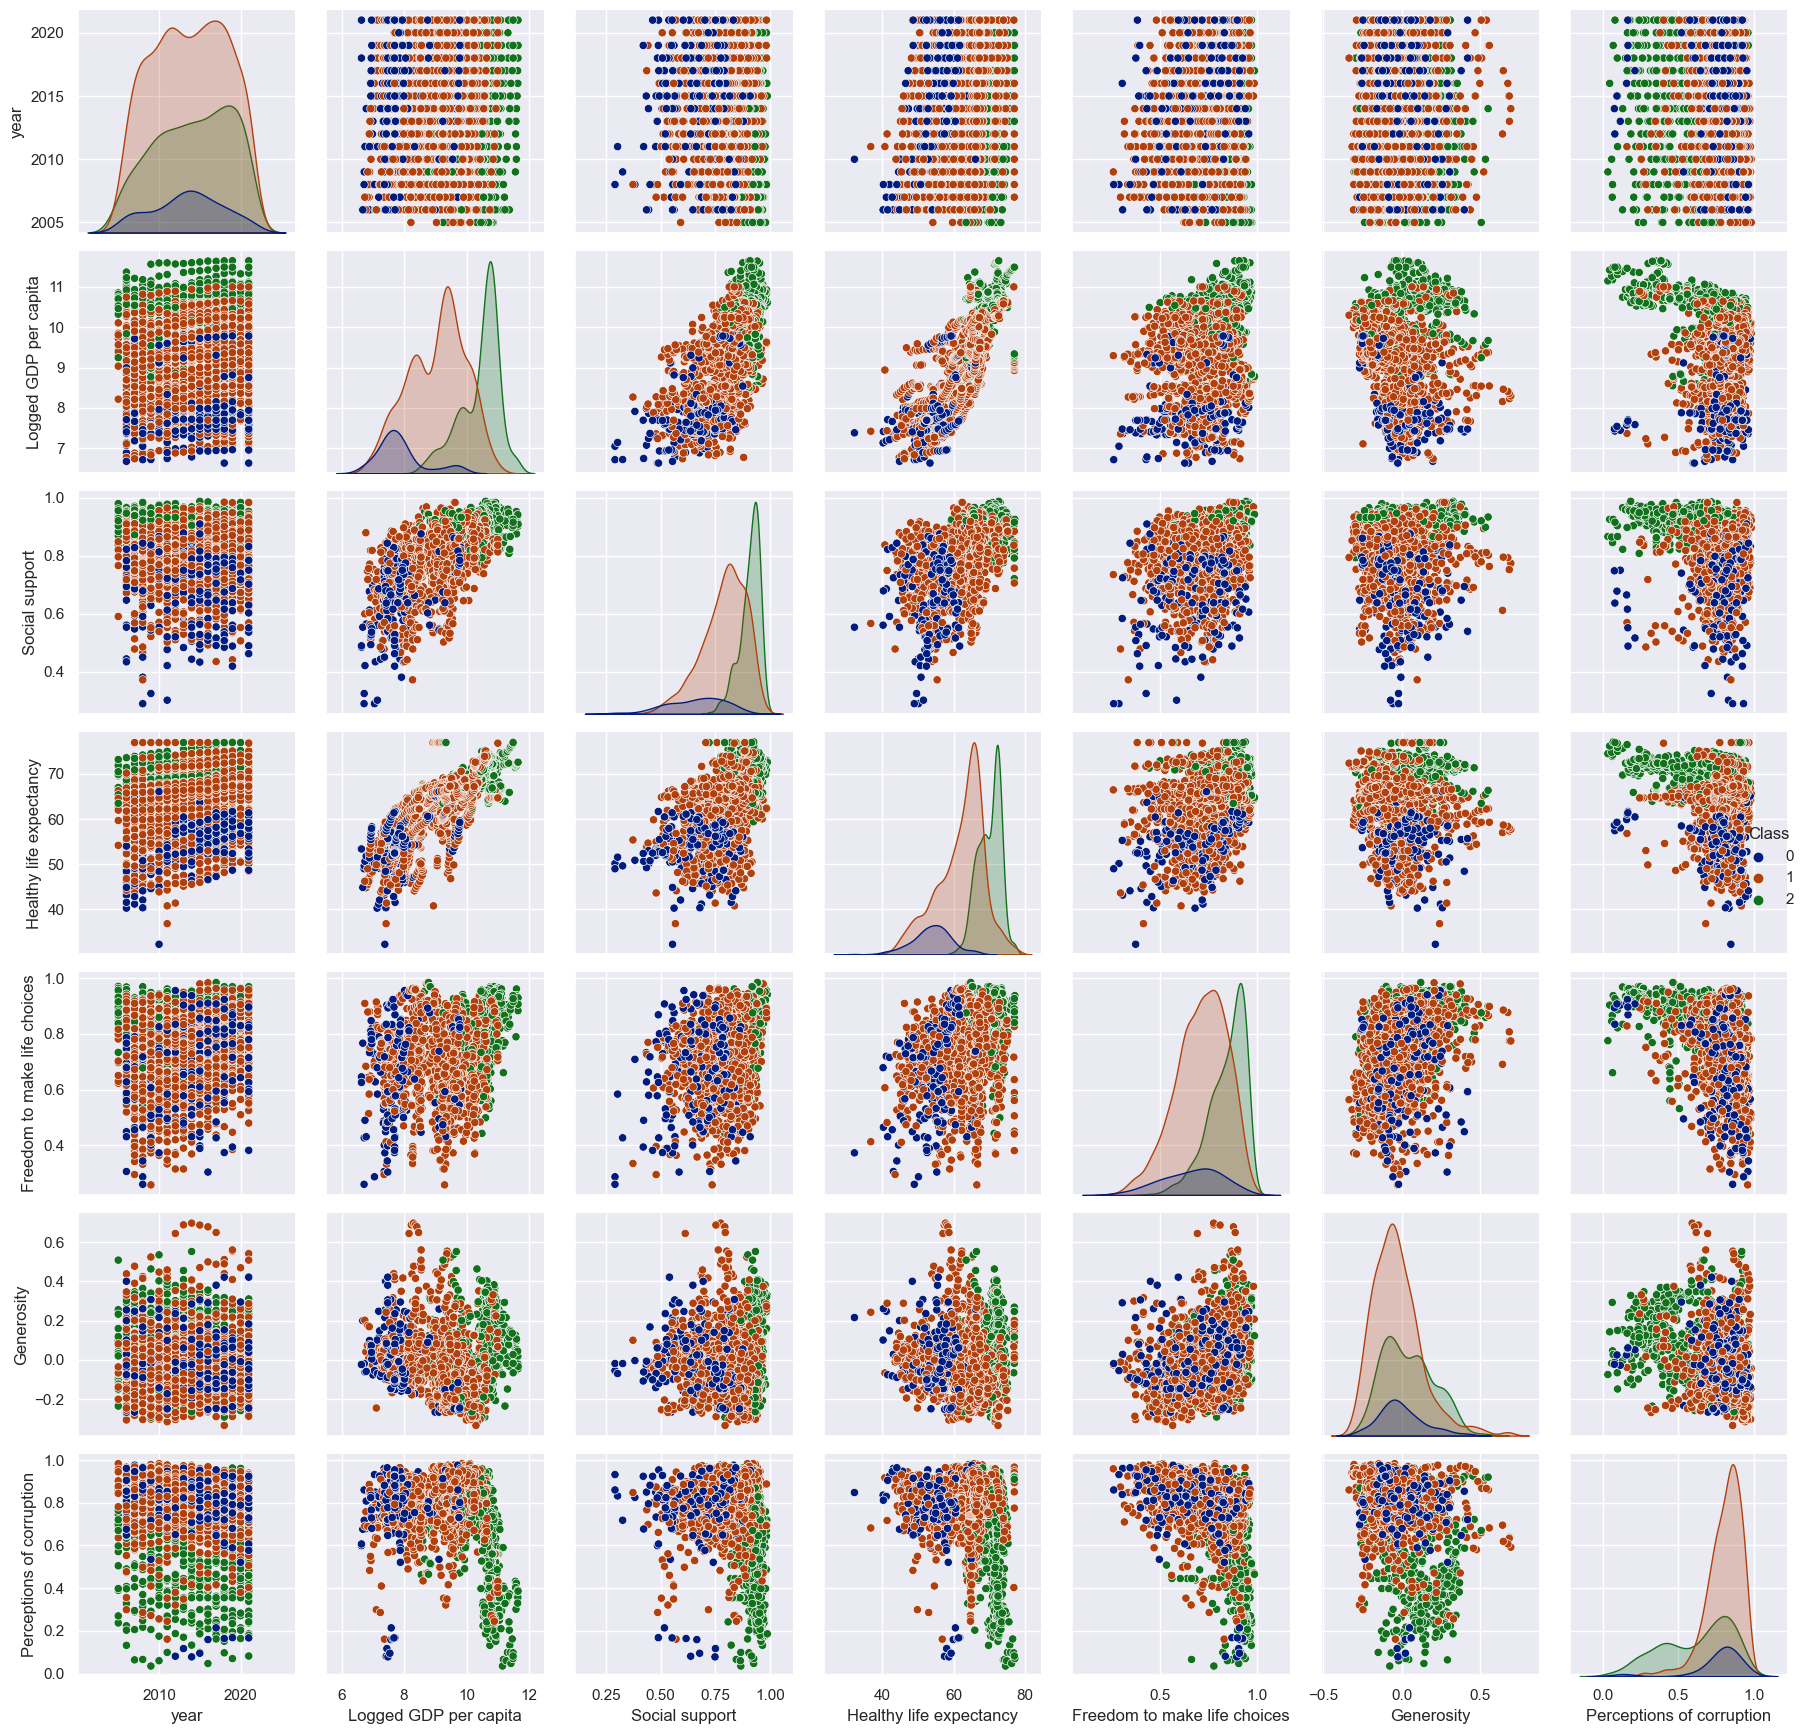

In [356]:
sns.set(font_scale=2)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.pairplot(data_regional_indicator.drop('Ladder score',axis=1),hue='Class',palette='dark')
plt.tight_layout()

##  **Logged GDP per capita has a very direct relationship with the Healthy life expectancy, and social support**

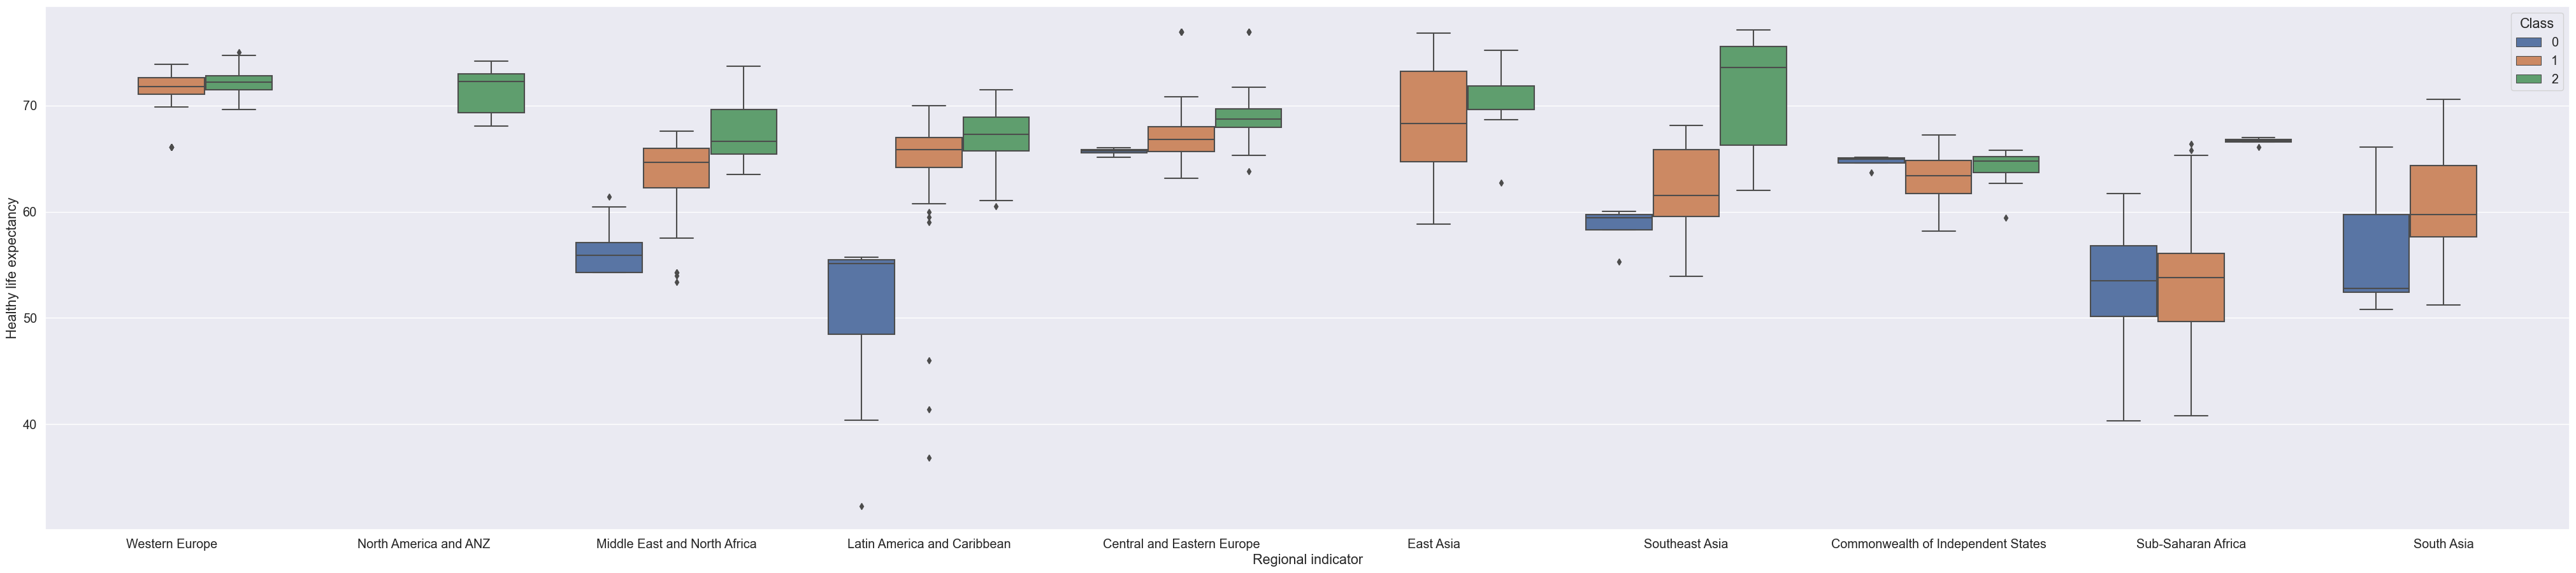

In [357]:
sns.set(rc={'figure.figsize':(40.7,9.27)})
sns.set(font_scale=1.3)
sns.boxplot(x='Regional indicator', y="Healthy life expectancy", hue="Class", data=data_regional_indicator)
plt.tight_layout()

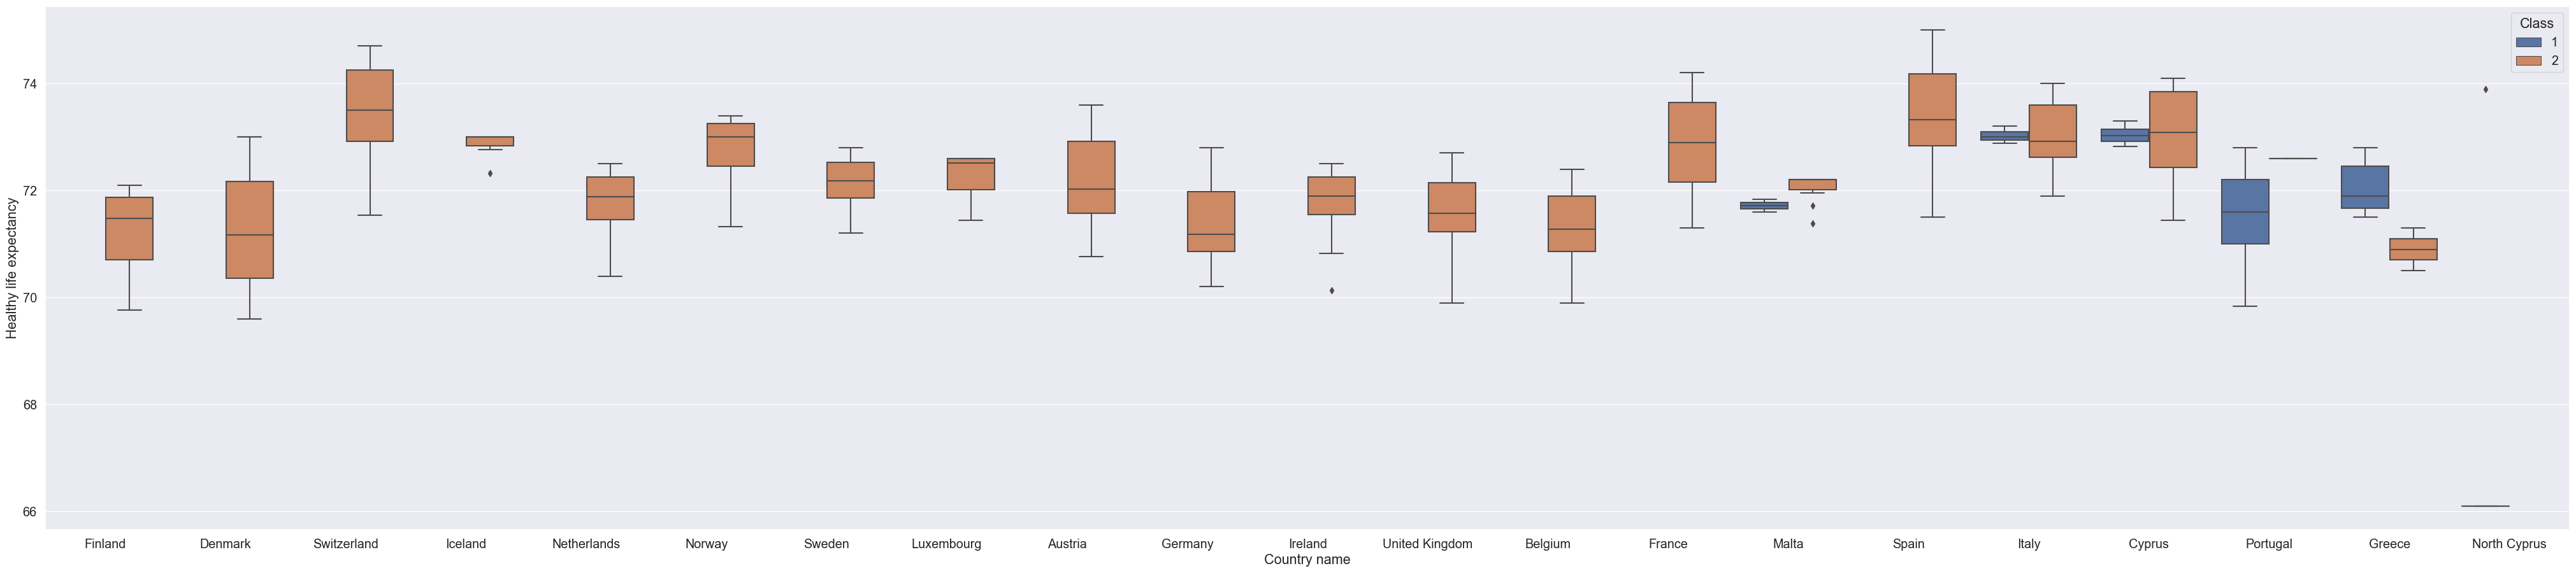

In [358]:
sns.set(rc={'figure.figsize':(40.7,9.27)})
sns.set(font_scale=1.3)
sns.boxplot(x='Country name', y="Healthy life expectancy", hue="Class", data=data_regional_indicator[data_regional_indicator['Regional indicator']=='Western Europe'])
plt.tight_layout()

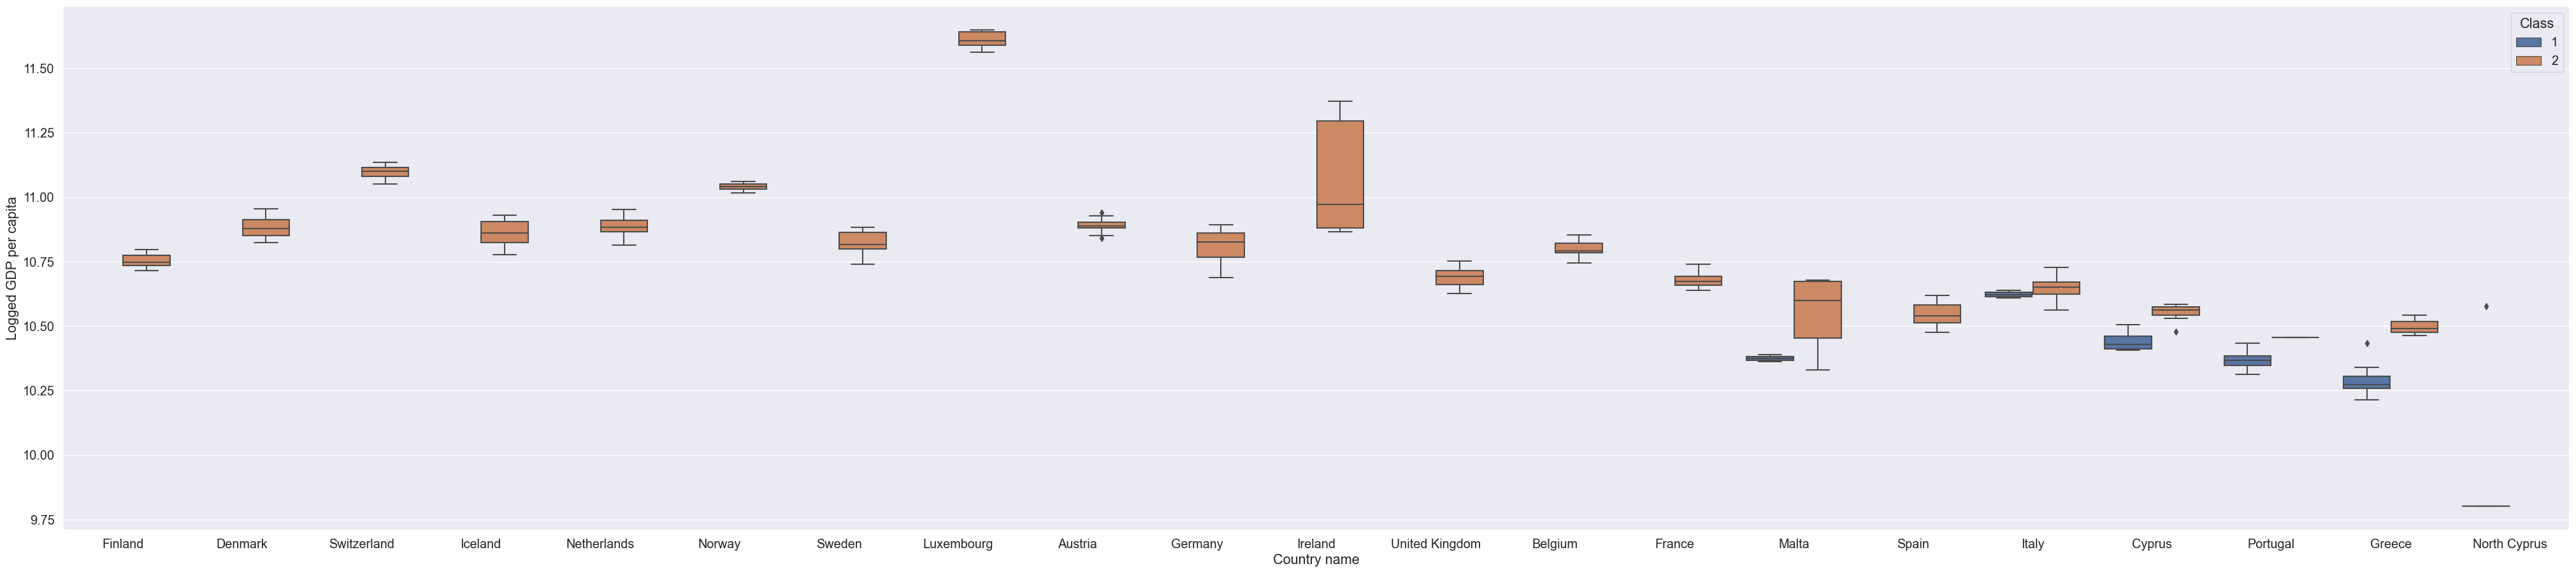

In [359]:
sns.set(rc={'figure.figsize':(40.7,9.27)})
sns.set(font_scale=1.3)
sns.boxplot(x='Country name', y="Logged GDP per capita", hue="Class", data=data_regional_indicator[data_regional_indicator['Regional indicator']=='Western Europe'])
plt.tight_layout()

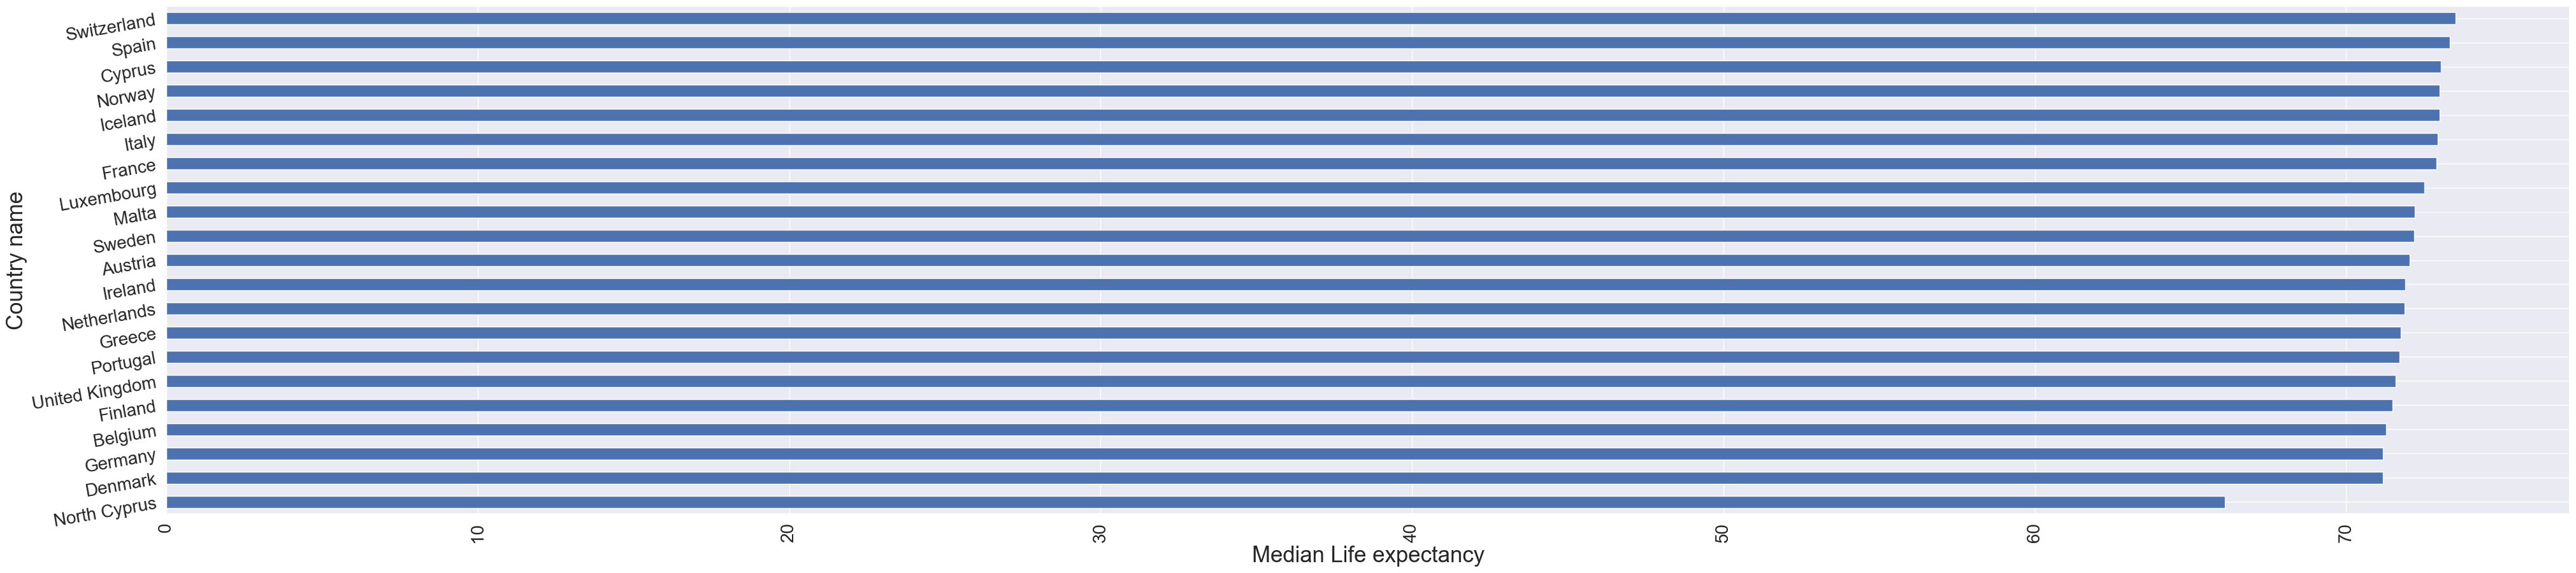

In [360]:
(data_regional_indicator[data_regional_indicator['Regional indicator']=='Western Europe']).groupby('Country name')['Healthy life expectancy'].median().sort_values(ascending=True).plot(kind='barh')
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20,rotation=10)
plt.xlabel('Median Life expectancy',fontsize=25)
plt.ylabel('Country name',fontsize=25)
plt.tight_layout()

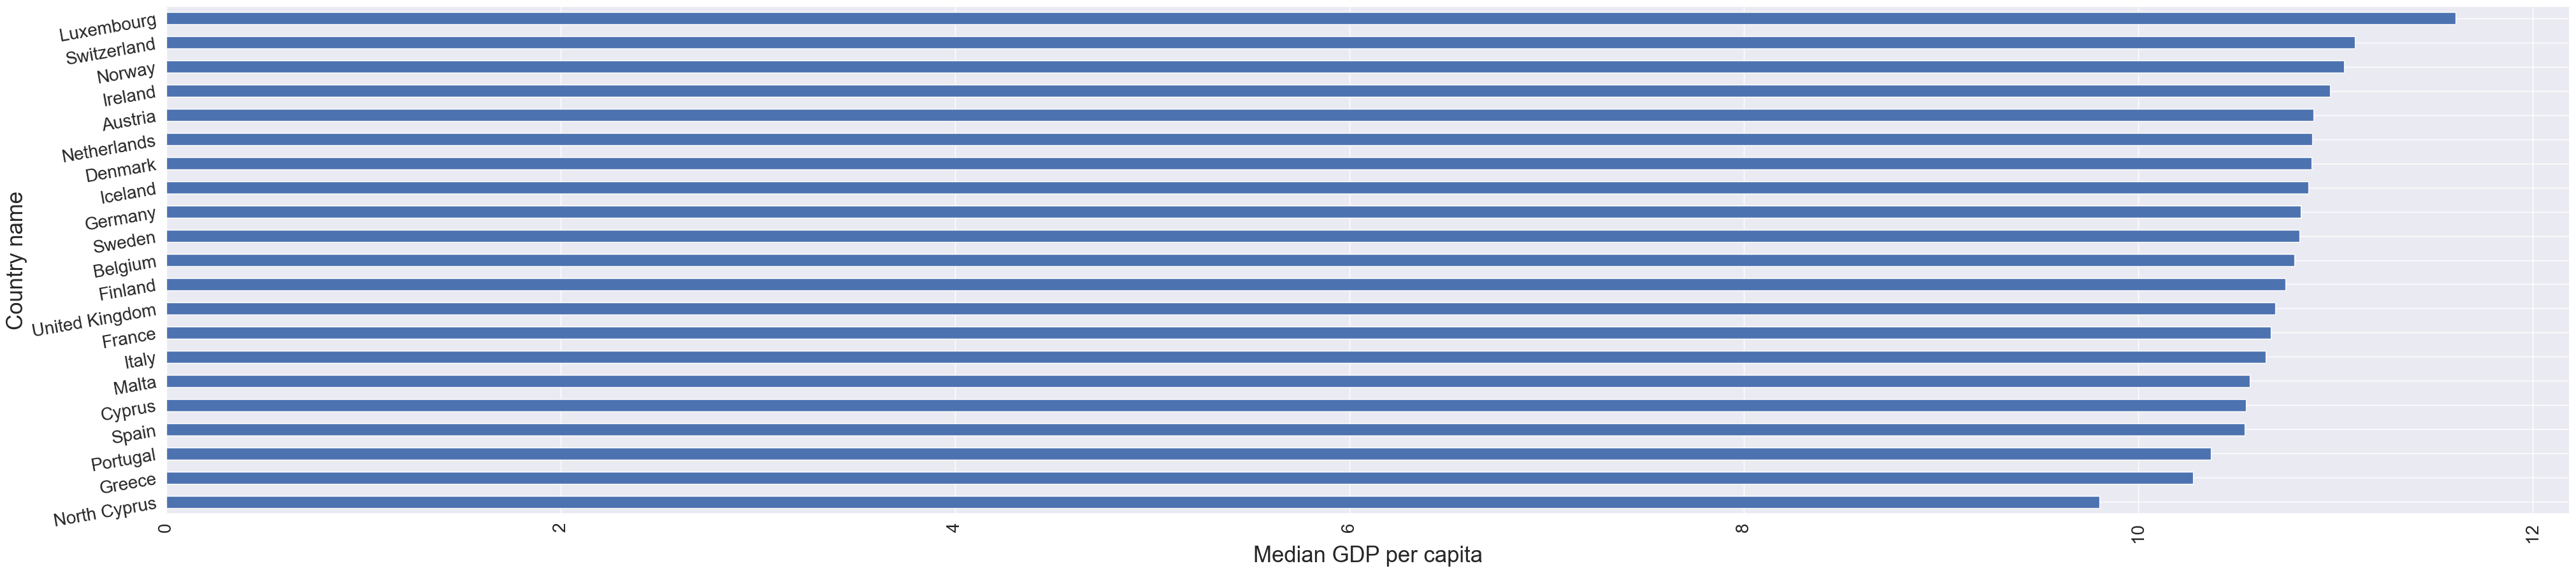

In [361]:
(data_regional_indicator[data_regional_indicator['Regional indicator']=='Western Europe']).groupby('Country name')['Logged GDP per capita'].median().sort_values(ascending=True).plot(kind='barh')
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20,rotation=10)
plt.xlabel('Median GDP per capita',fontsize=25)
plt.ylabel('Country name',fontsize=25)
plt.tight_layout()

## **Logged GDP per capita is low in Spain, and Cyprus. However, the life expectancy is higher than Luxembourg. This may be is because of the weather?** 
## I downloaded the GlobalTemperatureByCountry.csv from the NOAA webpage and data is already there in the sqlite table -- pulling it to the pandas dataframe now.

In [362]:
df_temperature = pd.DataFrame(rw_0,columns=hd_0)
#df_temperature.head(2)['datetime'][0].year
df_temperature['year'] = df_temperature['datetime'].apply(lambda x:x.split("-")[0])

In [363]:
df_temperature.drop(columns='datetime',inplace=True)

In [364]:
df_temperature[['AverageTemperature', 'AverageTemperatureUncertainty']]=df_temperature[['AverageTemperature', 'AverageTemperatureUncertainty']].replace('',np.nan).astype('float')

In [365]:
print(df_temperature.isnull().mean())
df_temperature.fillna(method='ffill',inplace=True)
print(df_temperature.isnull().mean())

AverageTemperature               0.013894
AverageTemperatureUncertainty    0.009823
Country                          0.000000
year                             0.000000
dtype: float64
AverageTemperature               0.0
AverageTemperatureUncertainty    0.0
Country                          0.0
year                             0.0
dtype: float64


In [366]:
Avg_Temp = pd.DataFrame(df_temperature.groupby(['year','Country'])['AverageTemperature'].mean()).reset_index()

In [367]:
Avg_Temp['year']=Avg_Temp['year'].astype('float')

In [368]:
data_regional_indicator = pd.merge(Avg_Temp,data_regional_indicator,left_on=['Country','year'],right_on=['Country name','year'])

In [369]:
data_regional_indicator=data_regional_indicator.sort_values(by='year')

In [371]:
data_regional_indicator.AverageTemperature = data_regional_indicator.AverageTemperature.apply(lambda x : (x*9/5)+32)

In [372]:
cols=(data_regional_indicator.drop(columns=['year','Country name','Country','Regional indicator','Class']).columns).to_list()

## Converting temperature to Fahrenheit.

In [373]:
scaler = MinMaxScaler()

In [374]:
le = LabelEncoder()
le.fit(data_regional_indicator['Country'])
data_regional_indicator['Encoded_Country'] = le.transform(data_regional_indicator['Country'])

In [375]:
X = data_regional_indicator.drop(['year','Country','Country name','Regional indicator','Ladder score','Encoded_Country','Class','Healthy life expectancy'],axis=1)
y = data_regional_indicator['Class']

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)

In [383]:
scaler.fit(X_train)
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)
X_train_transform_df = pd.DataFrame(X_train_transform)
X_train_transform_df.columns = X_train.columns
X_test_transform_df = pd.DataFrame(X_test_transform)
X_test_transform_df.columns = X_test.columns
X_test_transform_df.index = X_test.index
X_train_transform_df.index = X_train.index

In [409]:
y_test = y_test.astype(int)
y_train = y_train.astype(int)

In [418]:
#params = {'learning_rate':[0.1,0.09,0.05],'max_depth':[2,3,4],'n_estimators':[100,200]} ## I am optimizing the XgBoost using the maximum depth and the learning rate. Hyper parameter tuning is an art.
params = {'learning_rate':[0.1,0.09,0.05,0.02],'max_depth':[2,3,4,5],'n_estimators':[100,200]}
model = xgboost.sklearn.XGBClassifier(objective='multi:softmax')#,eval_metric='mlogloss')

Output = predict_fit(model,6,params,'recall_micro',X_train_transform_df,y_train,X_test_transform_df,y_test)

Features


Text(0.3, 0.5, 'Macro Average AUC score = 0.9098')

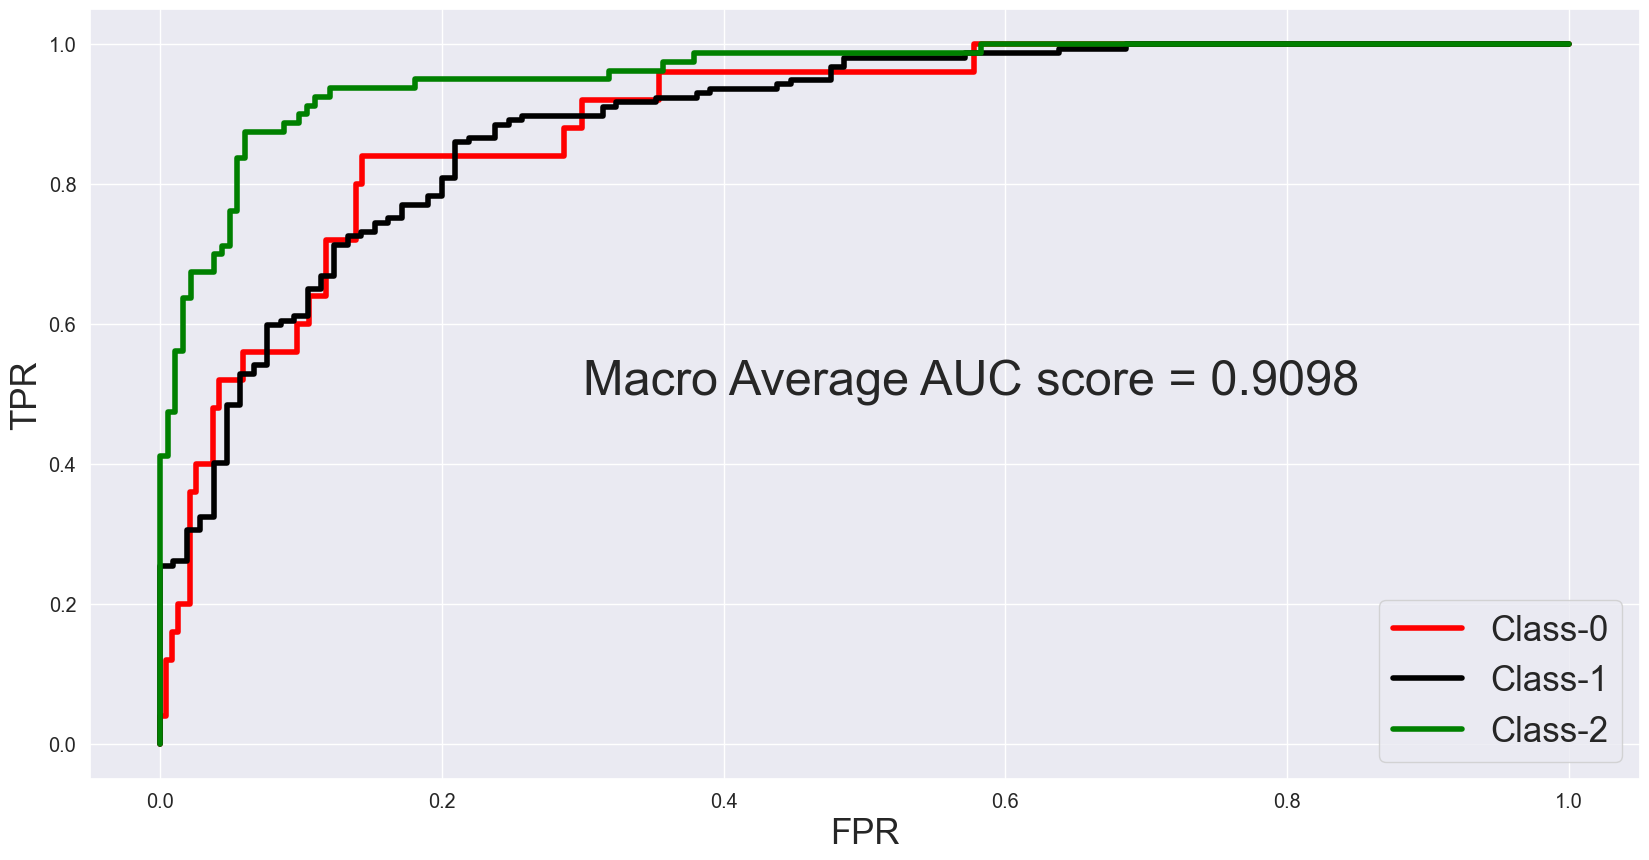

In [419]:
plt.figure(figsize=(20,10))
plt.plot(Output['fpr_1'],Output['tpr_1'],color='red',linewidth=4,label='Class-0')
plt.plot(Output['fpr_2'],Output['tpr_2'],color='black',linewidth=4,label='Class-1')
plt.plot(Output['fpr_3'],Output['tpr_3'],color='green',linewidth=4,label='Class-2')
plt.xlabel('FPR',fontsize=25)
plt.ylabel('TPR',fontsize=25)
plt.legend(loc='best',fontsize=25)
plt.annotate('Macro Average AUC score = {}'.format(round(Output['accuracy'],4)),(0.3,0.5),fontsize=35)

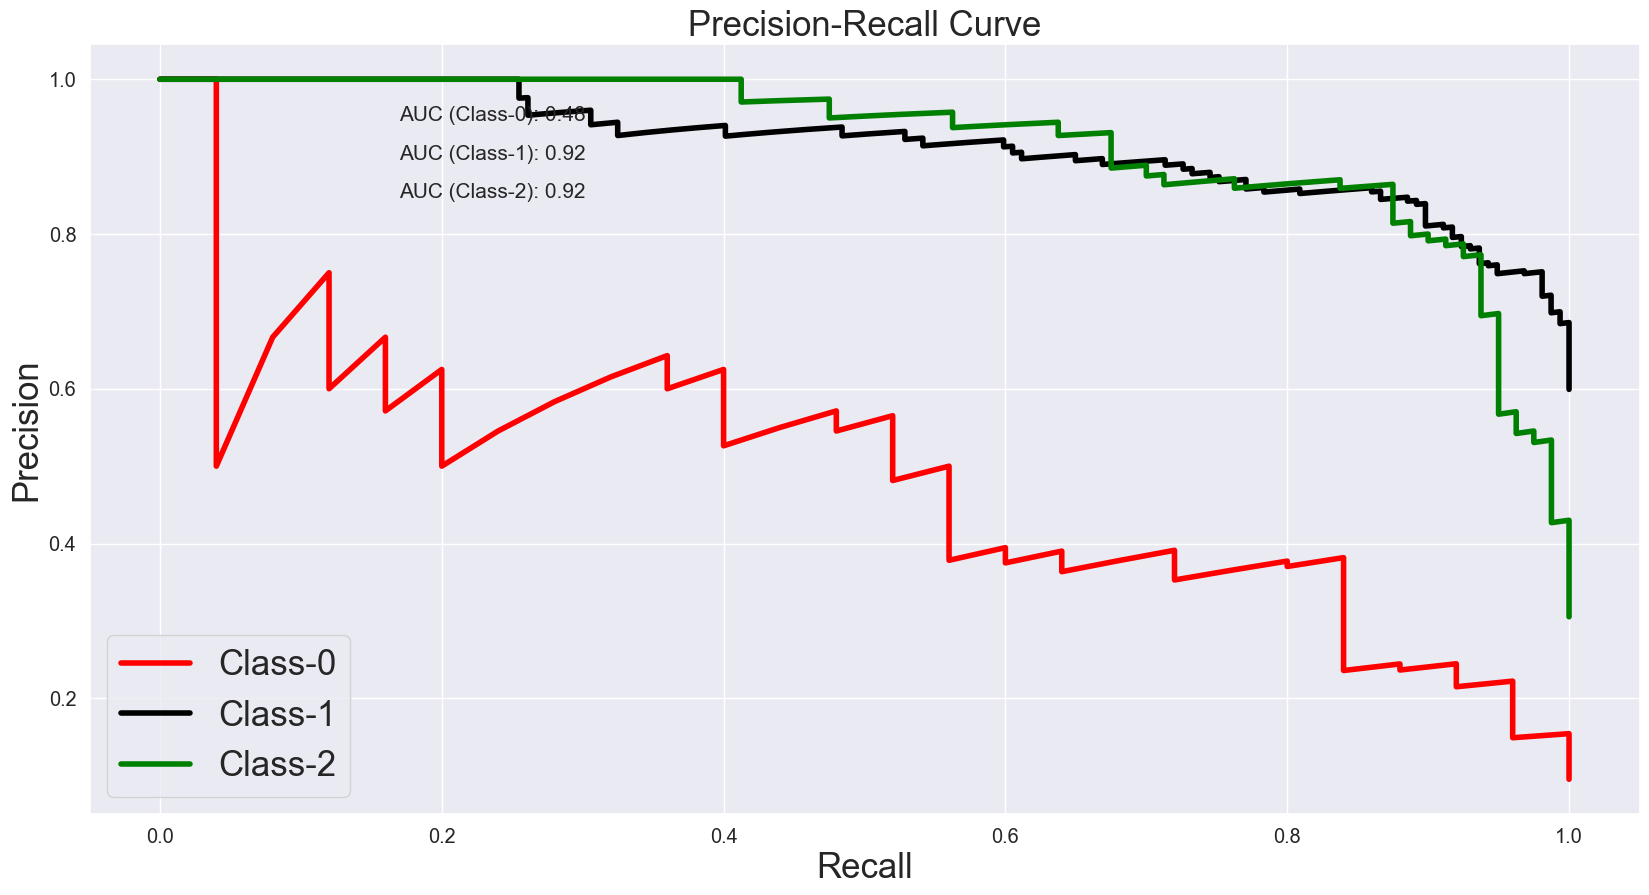

In [435]:


plt.figure(figsize=(20, 10))
plt.plot(Output['re_1'], Output['pr_1'], color='red', linewidth=4, label='Class-0')
plt.plot(Output['re_2'], Output['pr_2'], color='black', linewidth=4, label='Class-1')
plt.plot(Output['re_3'], Output['pr_3'], color='green', linewidth=4, label='Class-2')
plt.xlabel('Recall', fontsize=25)
plt.ylabel('Precision', fontsize=25)
plt.legend(loc='best', fontsize=25)
plt.title('Precision-Recall Curve', fontsize=25)

# Calculate the area under the precision-recall curve
auc_1 = auc(Output['re_1'], Output['pr_1'])
auc_2 = auc(Output['re_2'], Output['pr_2'])
auc_3 = auc(Output['re_3'], Output['pr_3'])

# Round the AUC values to two decimal places
auc_1 = round(auc_1, 2)
auc_2 = round(auc_2, 2)
auc_3 = round(auc_3, 2)

# Display the AUC values on the plot
plt.annotate(f'AUC (Class-0): {auc_1}', xy=(0.2, 0.9), fontsize=15, xycoords='axes fraction')
plt.annotate(f'AUC (Class-1): {auc_2}', xy=(0.2, 0.85), fontsize=15, xycoords='axes fraction')
plt.annotate(f'AUC (Class-2): {auc_3}', xy=(0.2, 0.8), fontsize=15, xycoords='axes fraction')

plt.show()



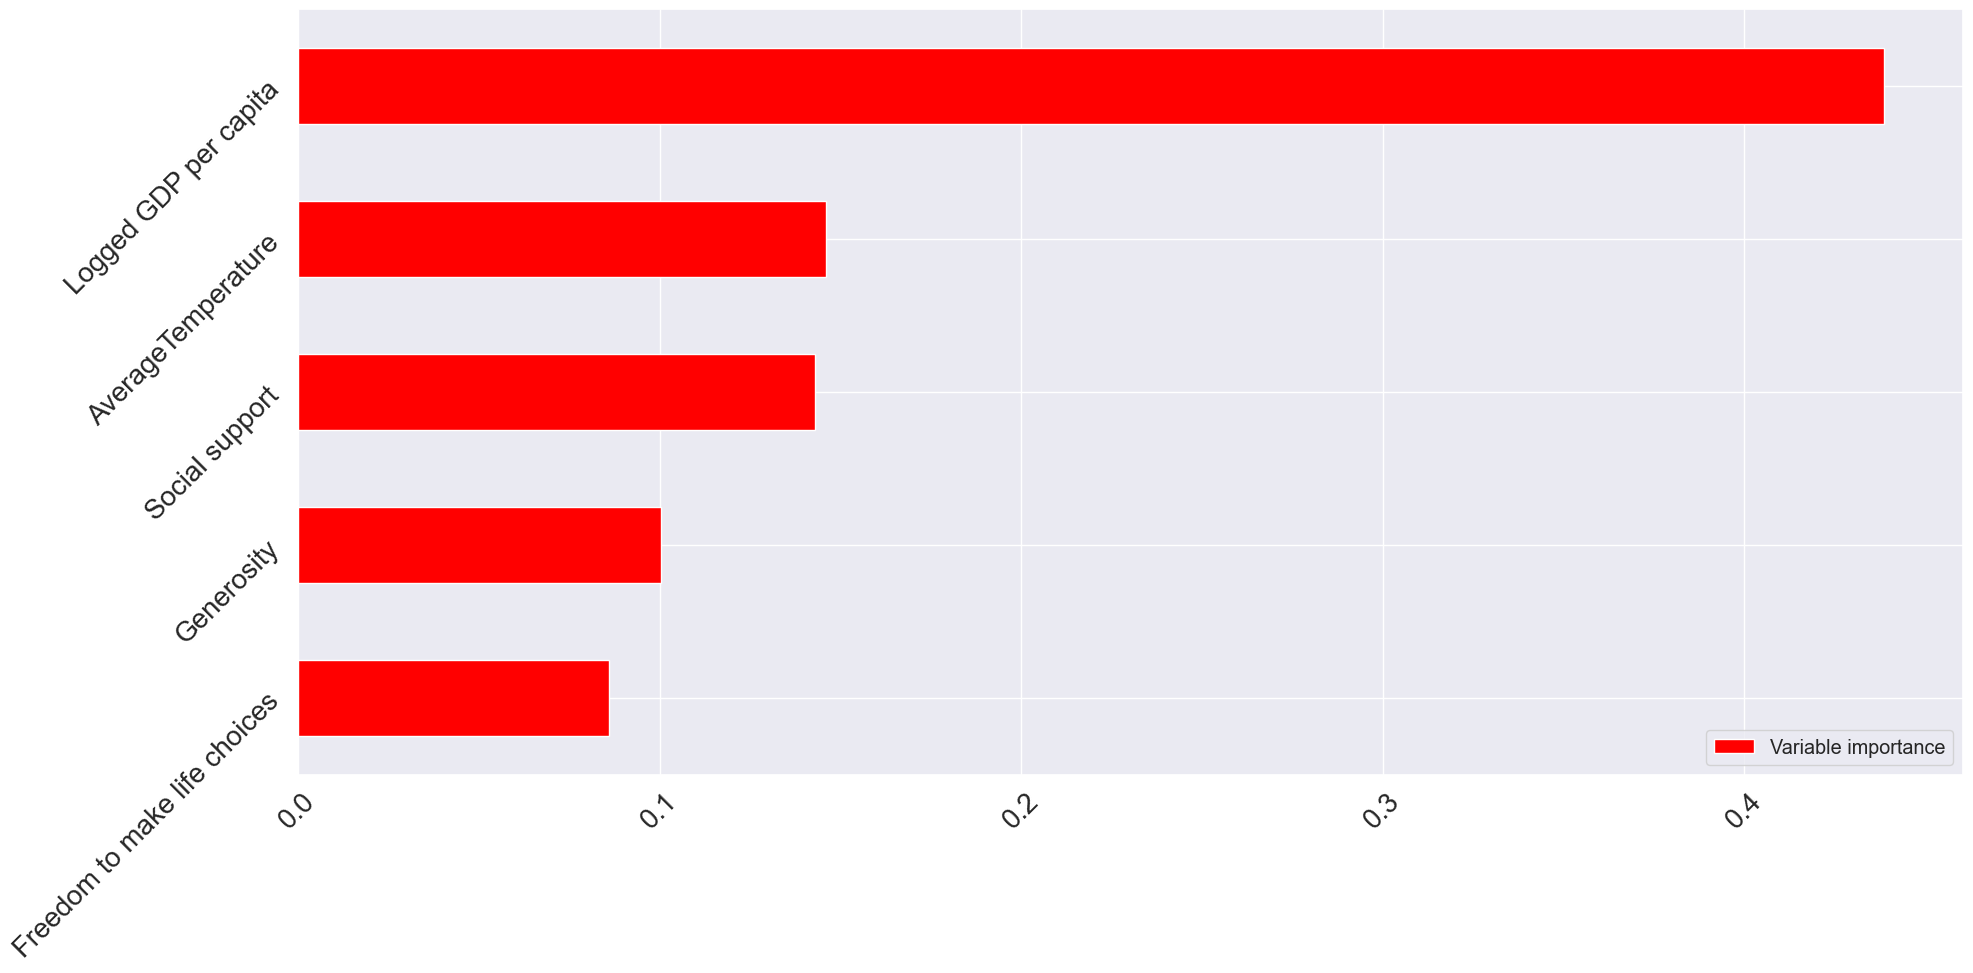

In [415]:
feature_names = list(X.columns)
forest_importances = pd.DataFrame(Output['model'].feature_importances_, index=feature_names).rename(columns={0:'Variable importance'})
forest_importances[0:5].sort_values(by='Variable importance').plot(kind='barh',rot=0,color='red',figsize=(20,10))
plt.legend(loc='best')
plt.xticks(rotation=45,fontsize=20)
plt.yticks(rotation=45,fontsize=20)
plt.tight_layout()

Text(212.25, 0.5, 'True Class')

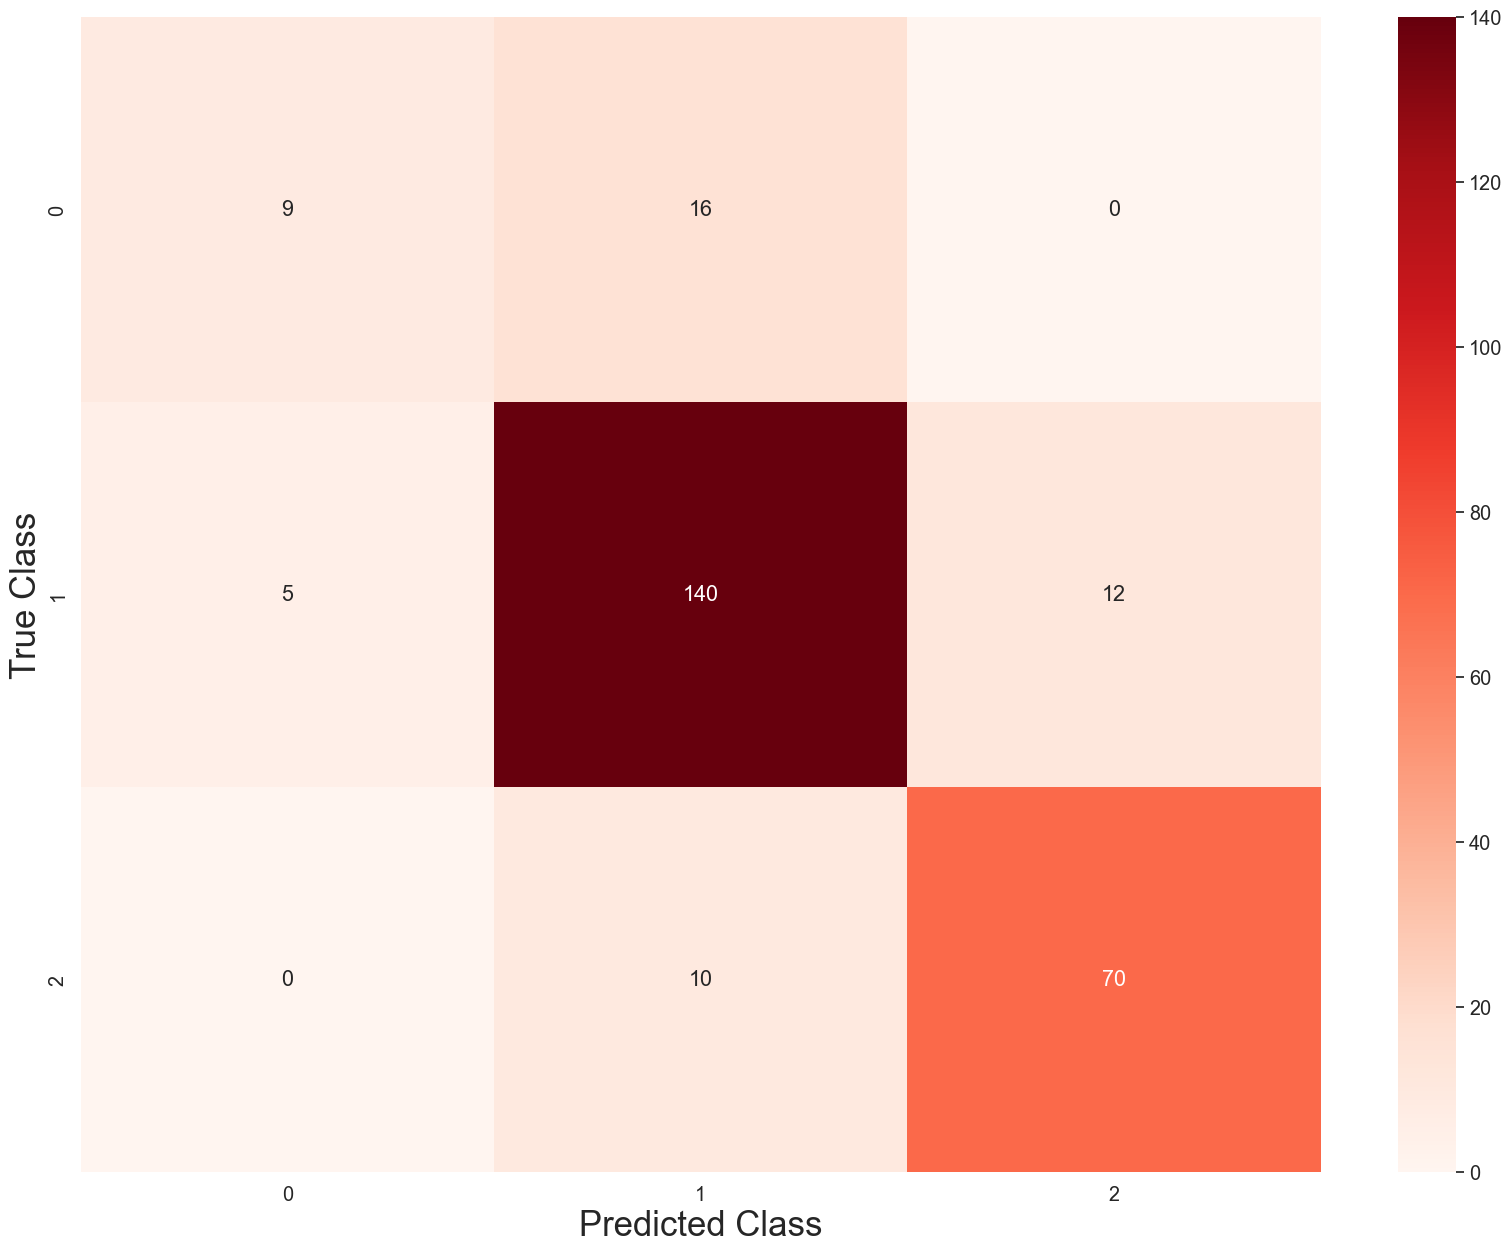

In [439]:
plt.figure(figsize=(20,15))
sns.heatmap(confusion_matrix(y_test,Output['predictions']),annot=True,fmt='',cmap='Reds',cbar=True)
plt.xlabel('Predicted Class',fontsize=25)
plt.ylabel('True Class',fontsize=25)

<div style="background-color: white; padding: 10px;">
<span style="color:blue; font-weight:bold">Based on the analysis of the World Happiness Survey and Global Temperature data, we can draw the following conclusion:</span>

<span style="color:black">The analysis reveals a strong positive correlation between happiness scores and various factors such as GDP per capita, social support, healthy life expectancy, freedom to make life choices, and perceptions of corruption. Countries with higher values in these factors tend to have higher happiness scores.</span>

<span style="color:black">Furthermore, incorporating the global temperature data into the analysis provides insights into the relationship between temperature and happiness. The analysis shows that countries with moderate temperature ranges tend to have higher happiness scores, indicating a potential link between climate and happiness.</span>

<span style="color:black">It is important to note that the analysis is based on observational data, and causation cannot be established directly. However, the findings highlight the importance of factors like socioeconomic conditions and climate in influencing happiness levels.</span>

<span style="color:black">This analysis can be valuable for policymakers, researchers, and individuals interested in understanding the factors that contribute to happiness and the potential impact of global temperature on well-being. Further research and exploration in this area can provide more in-depth insights and contribute to creating happier and more sustainable societies.</span>
</div>
